In [3]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

# datasets
from my_code.datasets.surreal_cached_train_dataset import SurrealTrainDataset
from my_code.datasets.surreal_cached_test_dataset import SurrealTestDataset

# models
from my_code.models.diag_conditional import DiagConditionedUnet
from diffusers import DDPMScheduler

import yaml
import torch

sys.path.append('/home/s94zalek/shape_matching/pyFM_fork')

import pyFM

In [67]:
from my_code.datasets.surreal_dataset import SingleSurrealDataset

n_body_types_male=2
n_body_types_female=0
n_poses_straight=0
n_poses_bent=4
num_evecs=200

# create the dataset
dataset = SingleSurrealDataset(
    n_body_types_male=n_body_types_male,
    n_body_types_female=n_body_types_female,
    n_poses_straight=n_poses_straight,
    n_poses_bent=n_poses_bent,
    num_evecs=num_evecs
)

Generating male shapes: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.89it/s]
Generating female shapes: 0it [00:00, ?it/s]


In [11]:
from pyFM.refine.zoomout import zoomout_refine

In [68]:
data_10 = dataset[5]

In [69]:
Cxy_full = data_10['second']['C_gt_xy']

init_dim = 16
out_dim = 64

Cxy_init = Cxy_full[:init_dim, :init_dim]
Cxy_gt = Cxy_full[:out_dim, :out_dim]

Cxy_refined = zoomout_refine(
    FM_12=Cxy_init.numpy(), 
    evects1=data_10['first']['evecs'].numpy(), 
    evects2=data_10['second']['evecs'].numpy(),
    nit=out_dim - init_dim, step=1,
    verbose=True
)

  0%|          | 0/48 [00:00<?, ?it/s]

Correct signs: 91.10%, Incorrect signs: 8.90%


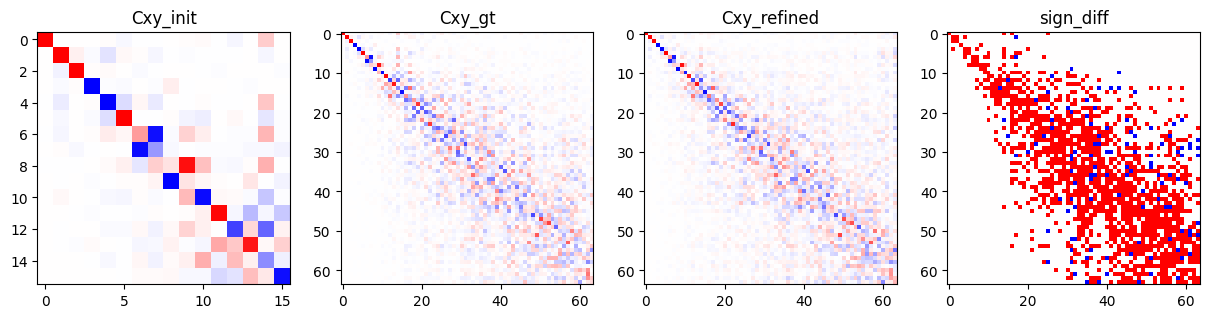

In [71]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 4, figsize=(15, 5))

ax_0 = ax[0].imshow(Cxy_init, cmap='bwr', vmin=-1, vmax=1)
ax[0].set_title('Cxy_init')
# plt.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(Cxy_gt, cmap='bwr', vmin=-1, vmax=1)
ax[1].set_title('Cxy_gt')
# plt.colorbar(ax_1, ax=ax[1])

ax_2 = ax[2].imshow(Cxy_refined, cmap='bwr', vmin=-1, vmax=1)
ax[2].set_title('Cxy_refined')
# plt.colorbar(ax_2, ax=ax[2])

sign_diff = np.sign(Cxy_gt) * np.sign(Cxy_refined)
sign_diff = sign_diff * (np.abs(Cxy_gt) > 0.05)

ax_3 = ax[3].imshow(sign_diff, cmap='bwr')
ax[3].set_title('sign_diff')
# plt.colorbar(ax_3, ax=ax[3])


print(f'Correct signs: {100 * torch.sum(sign_diff == 1) / torch.sum(sign_diff != 0):.2f}%, '
      f'Incorrect signs: {100 * torch.sum(sign_diff == -1) / torch.sum(sign_diff != 0):.2f}%')

plt.show()


In [64]:
torch.sum(torch.abs(torch.tensor(Cxy_refined) - Cxy_gt))

tensor(253.8035)

In [45]:
np.sum(sign_diff == 1)

TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)
